# Notebook for Generating Plots and Figures

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('bugs.csv')
print(f"Loadede {len(df)} rows.")
df[df["Database"] == "MySQL"].head()

Loadede 115 rows.


,Bug ID,Reported In,URL,Database,Version / Commit,R Uncommitted,R Committed,Repeatable R,Serializable,Pessimistic,Optimistic,Interesting,Bug summary,Transaction Bug,Bug type,Deterministic,# Connections,Root cause,Issue closed
33,MYSQL-100293,ICSE2024,https://bugs.mysql.com/bug.php?id=100293,MySQL,5.7.31,False,False,False,True,False,False,True,The SERIALIZABLE transactions are not blocked ...,True,Missing blocking,True,2,NaN,True
34,MYSQL-100328,ICSE2024,https://bugs.mysql.com/bug.php?id=100328,MySQL,5.7.22,True,True,True,True,False,False,False,UPDATE does not update all records,True,Incorrect database state,True,2,NaN,False
35,MYSQL-102722,ICSE2024,https://bugs.mysql.com/bug.php?id=102722,MySQL,8.0.26,True,True,True,True,False,False,False,Locks on secondary indexes are not released ev...,True,Unnecessary blocking,True,1,NaN,True
36,MYSQL-104245,ICSE2024,https://bugs.mysql.com/bug.php?id=104245,MySQL,5.7.34,False,True,True,False,False,False,True,There are too many row locks issued.,True,Unnecessary blocking,True,1,NaN,False
37,MYSQL-107066,OSDI2023,https://bugs.mysql.com/bug.php?id=107066,MySQL,8.0.23,True,True,True,True,False,False,False,Rollback does not revert autoincemented keys,True,Incorrect database state,True,2,NaN,False


In [35]:
paper_to_title = {
    "Other": "Other",
    "ASE2022": "DT2 (ASE 2022)",
    "ICSE2024": "Survey Paper (ICSE 2024)",
    "OSDI2023": "TxCheck (OSDI 2023)",
}

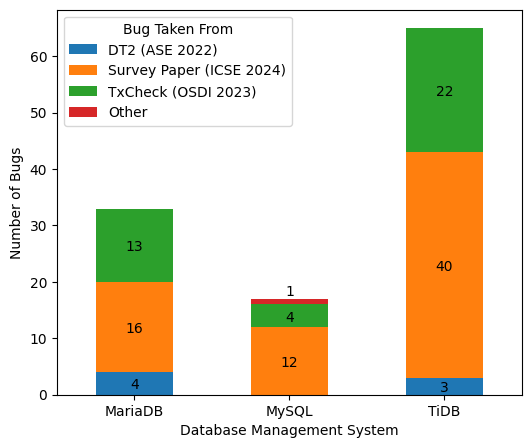

In [36]:
# Group by 'Database' and 'Reported In' and count the number of bugs
grouped = df.groupby(['Database', 'Reported In']).size().unstack().fillna(0)

# Rename the 'Reported In' field
grouped.columns = grouped.columns.map(lambda s: paper_to_title[s])

# Plot the data
ax = grouped.plot(kind='bar', stacked=True, ylabel='Number of Bugs', xlabel='Database Management System', figsize=(6, 5))

# Annotate the bars with the number of bugs
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height == 0:
        continue
    x, y = p.get_xy()
    new_x = x + width / 2
    new_y = y + height / 2 - 1
    if height == 1:
        new_y += 2
    ax.annotate(f'{height:.0f}', (new_x, new_y), ha='center')
ax.set_xticklabels(grouped.index, rotation=0, ha='center')
plt.legend(title='Bug Taken From')

plt.savefig('../assets/bug_replication_bugs_by_dbms_and_paper.png', dpi=300, bbox_inches='tight')

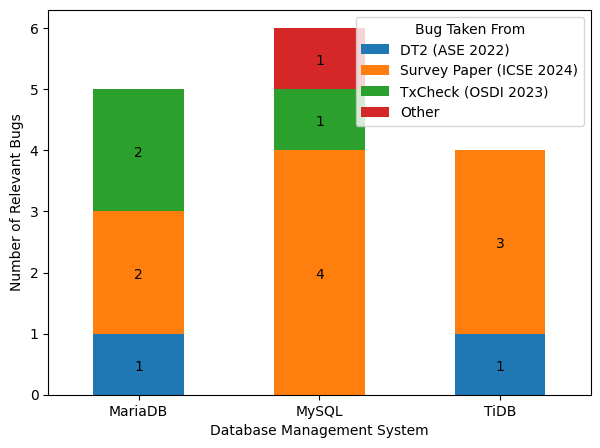

In [37]:
# Group by 'Database' and 'Reported In' and count the number of bugs
interesting = df[df["Interesting"] == True]
grouped = interesting.groupby(['Database', 'Reported In']).size().unstack().fillna(0)

# Rename the 'Reported In' field
grouped.columns = grouped.columns.map(lambda s: paper_to_title[s])

# Plot the data
ax = grouped.plot(kind='bar', stacked=True, ylabel='Number of Relevant Bugs', xlabel='Database Management System', figsize=(7, 5))

# Annotate the bars with the number of bugs
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height == 0:
        continue
    x, y = p.get_xy()
    new_x = x + width / 2
    new_y = y + height / 2 - 0.1
    ax.annotate(f'{height:.0f}', (new_x, new_y), ha='center')
ax.set_xticklabels(grouped.index, rotation=0, ha='center')

# Move legend to top right
plt.legend(title='Bug Taken From', loc='upper right')




plt.savefig('../assets/bug_replication_interesting_bugs_by_dbms_and_paper.png', dpi=300, bbox_inches='tight')

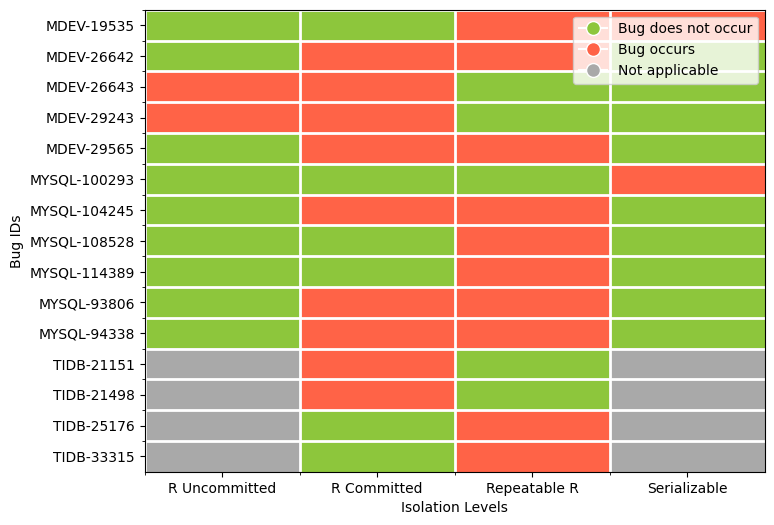

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Take all bugs with "Interesting" == True
# Assuming "Interesting" column exists and has boolean values
intersting_bugs = df[df["Interesting"] == True]

isol_lvls = ["R Uncommitted", "R Committed", "Repeatable R", "Serializable"]

# Isolate columns Bug ID and isol_lvls
isolated = intersting_bugs[["Bug ID", "Database"] + isol_lvls]

# Modify the matrix to set RU and S to -1 for TiDB bugs
matrix = isolated.set_index("Bug ID")
matrix[isol_lvls] = matrix[isol_lvls].astype(int)  # Convert boolean to int
matrix.loc[matrix["Database"] == "TiDB", ["R Uncommitted", "Serializable"]] = -1
matrix = matrix.drop(columns=["Database"])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a custom colormap with slightly darker shades of green and red, and grey for -1
colors = ['#A9A9A9', '#8DC63C', '#FF6347']  # Darker green, darker red, grey
cmap = mcolors.ListedColormap(colors)
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the matrix with white space between squares using imshow
cax = ax.imshow(matrix, cmap=cmap, norm=norm, aspect='auto')

# Add grid lines to create white space between squares
ax.set_xticks(np.arange(len(isol_lvls)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(matrix.index)) - 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)

# Set major ticks and labels
ax.set_xticks(np.arange(len(isol_lvls)))
ax.set_yticks(np.arange(len(matrix.index)))
ax.set_xticklabels(isol_lvls)
ax.set_yticklabels(matrix.index)

# Center x-axis labels for better readability
plt.xticks(rotation=0, ha='center')

# Add labels
ax.set_xlabel('Isolation Levels')
ax.set_ylabel('Bug IDs')

# Add legend
legend_labels = {0: 'Bug does not occur', 1: 'Bug occurs', -1: 'Not applicable'}
legend_colors = {0: '#8DC63C', 1: '#FF6347', -1: '#A9A9A9'}  # Darker green, darker red, grey
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors[k], markersize=10) for k in legend_labels]
ax.legend(legend_patches, legend_labels.values(), loc='upper right')

plt.savefig('../assets/bug_replication_interesting_bugs_by_isolation_lvl.png', dpi=300, bbox_inches='tight')


In [39]:
matrix

,R Uncommitted,R Committed,Repeatable R,Serializable
Bug ID,,,,
MDEV-19535,0,0,1,1
MDEV-26642,0,1,1,0
MDEV-26643,1,1,0,0
MDEV-29243,1,1,0,0
MDEV-29565,0,1,1,0
MYSQL-100293,0,0,0,1
MYSQL-104245,0,1,1,0
MYSQL-108528,0,0,1,0
MYSQL-114389,0,0,1,0


In [44]:
# Extract the bug ids (index of matrix)
for i in matrix.index:
    print(f"\subsection*{{Bug {i}}}")

\subsection*{Bug MDEV-19535}
\subsection*{Bug MDEV-26642}
\subsection*{Bug MDEV-26643}
\subsection*{Bug MDEV-29243}
\subsection*{Bug MDEV-29565}
\subsection*{Bug MYSQL-100293}
\subsection*{Bug MYSQL-104245}
\subsection*{Bug MYSQL-108528}
\subsection*{Bug MYSQL-114389}
\subsection*{Bug MYSQL-93806}
\subsection*{Bug MYSQL-94338}
\subsection*{Bug TIDB-21151}
\subsection*{Bug TIDB-21498}
\subsection*{Bug TIDB-25176}
\subsection*{Bug TIDB-33315}


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_383644/3664737524.py:3: SyntaxWarning: invalid escape sequence '\s'
  print(f"\subsection*{{Bug {i}}}")
